In [3]:
%pylab inline
import numpy as np
import cPickle as pickle
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [4]:
current_palette = sns.color_palette()
read_color = current_palette[0]
write_color = current_palette[1]

In [ ]:
# python s3_benchmark.py write --bucket_name=jonas-pywren-benchmark --mb_per_file=2000 --number=1800 --key_file=big_keys.txt
# python s3_benchmark.py read --bucket_name=jonas-pywren-benchmark  --number=1800 --key_file=big_keys.txt

In [17]:
runtime_bins = np.linspace(0, 150, 150)

    
def compute_times_rates(d):
    
    x = np.array(d)
    tzero = np.min(x[:, :2])
    start_time = x[:, 0] - tzero
    end_time = x[:, 1]  - tzero
    rate = x[:, 2]

    N = len(start_time)

    runtime_rate_hist = np.zeros((N, len(runtime_bins)))
    runtime_jobs_hist = np.zeros((N, len(runtime_bins)))

    for i in range(N):
        s = start_time[i]
        e = end_time[i]
        a, b = np.searchsorted(runtime_bins, [s, e])
        if b-a > 0:
            runtime_rate_hist[i, a:b] = rate[i]
            runtime_jobs_hist[i, a:b] = 1

    return {'start_time' : start_time, 
            'end_time' : end_time, 
            'rate' : rate, 
            'runtime_rate_hist' : runtime_rate_hist, 
            'runtime_jobs_hist' : runtime_jobs_hist}
read_data = pickle.load(open("/data/jonas/pywren/examples/s3_benchmark.read.output.pickle", 'r'))
read  = compute_times_rates(read_data)
write_data = pickle.load(open("/data/jonas/pywren/examples/s3_benchmark_write.2800.output.pickle", 'r'))
write = compute_times_rates(write_data)


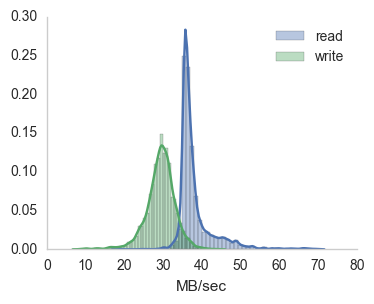

In [18]:
fig = pylab.figure(figsize=(4, 3))
sns.distplot(read['rate'], label='read', color=read_color)
sns.distplot(write['rate'], label='write', color=write_color)
pylab.legend()
pylab.xlabel("MB/sec")
pylab.grid(False)
sns.despine()


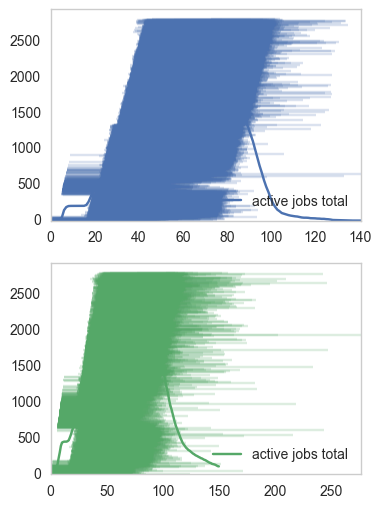

In [19]:
from matplotlib.collections import LineCollection

    
fig = pylab.figure(figsize=(4, 6))

for plot_i, (datum, l, c) in enumerate([(read, 'read', read_color), 
                                    (write, 'write', write_color)]):
    ax = fig.add_subplot(2, 1, 1 + plot_i)

    N = len(datum['start_time'])
    line_segments = LineCollection([[[datum['start_time'][i], i], 
                                     [datum['end_time'][i], i]] for i in range(N)],
                                   linestyles='solid', color=c, alpha=0.2)
    #line_segments.set_array(x)

    ax.add_collection(line_segments)

    ax.plot(runtime_bins, datum['runtime_jobs_hist'].sum(axis=0), c=c, label='active jobs total')


    ax.set_xlim(0, np.max(datum['end_time']))
    ax.set_ylim(0, len(datum['start_time'])*1.05)
    ax.grid(False)
    ax.legend(loc='lower right')

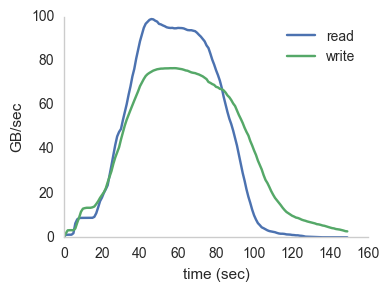

In [20]:
fig = pylab.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
for d, l, c in [(read, 'read', read_color), (write, 'write', write_color)]:
    
    ax.plot(d['runtime_rate_hist'].sum(axis=0)/1000, label=l, c=c)
ax.set_xlabel('time (sec)')
ax.set_ylabel("GB/sec")
pylab.legend()
ax.grid(False)
sns.despine()
fig.tight_layout()


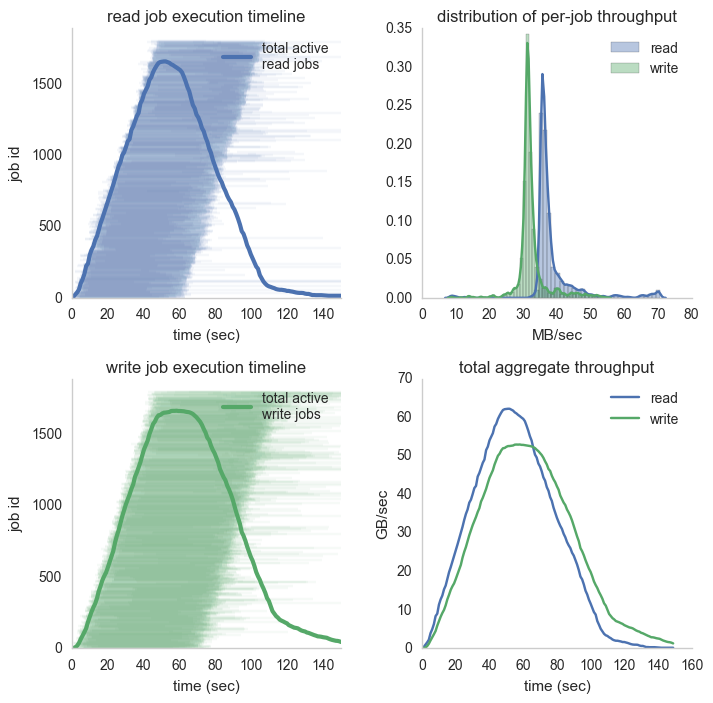

In [9]:
fig = pylab.figure(figsize=(8, 8))


gs = gridspec.GridSpec(2, 2, wspace=0.3, hspace=0.3)
jobs_r = plt.subplot(gs[0, 0])
jobs_w = plt.subplot(gs[1, 0])
rate_agg = plt.subplot(gs[1, 1])
rate_job = plt.subplot(gs[0, 1])

jobs_ax = [jobs_r, jobs_w]

for plot_i, (datum, l, c) in enumerate([(read, 'read', read_color), 
                                    (write, 'write', write_color)]):
    


    ax = jobs_ax[plot_i]

    N = len(datum['start_time'])
    line_segments = LineCollection([[[datum['start_time'][i], i], 
                                     [datum['end_time'][i], i]] for i in range(N)],
                                   linestyles='solid', color=c, alpha=0.05)
    #line_segments.set_array(x)

    ax.add_collection(line_segments)

    ax.plot(runtime_bins, datum['runtime_jobs_hist'].sum(axis=0), c=c, 
            label='total active\n{} jobs'.format(l), linewidth=3)


    ax.set_xlim(0, runtime_bins[-1])
    ax.set_ylim(0, len(datum['start_time'])*1.05)
    ax.grid(False)
    ax.legend(loc='upper right')

    ax.set_ylabel('job id')
    ax.set_title("{} job execution timeline".format(l))
    ax.set_xlabel("time (sec)")
    sns.distplot(datum['rate'], label=l, color=c, ax=rate_job)
    
    
        
    rate_agg.plot(datum['runtime_rate_hist'].sum(axis=0)/1000, label=l, c=c)


#rate_job.legend()
rate_job.set_xlabel("MB/sec")
rate_job.grid(False)

rate_job.set_title("distribution of per-job throughput")
rate_job.legend()
sns.despine(ax=rate_job)
sns.despine(ax=jobs_r)
sns.despine(ax=jobs_w)
sns.despine(ax=rate_agg)

rate_agg.grid(False)
rate_agg.set_xlabel('time (sec)')
rate_agg.set_ylabel("GB/sec")
rate_agg.set_title("total aggregate throughput")
rate_agg.legend()
fig.savefig("pywren.s3.png")
